In [1]:
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as tkr
import numpy as n
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

target_db = "dft-mot-results-and-test-items-2005-to-2020.sqlite"
con = sqlite3.connect(target_db)

In [12]:
df = pd.read_sql_query("""
    SELECT count(*) AS "Number of MOTs"
    FROM tests
""", con)
df

,Number of MOTs
0,551156643


In [3]:
df = pd.read_sql_query("""
    SELECT count(*) AS "Number of test items"
    FROM test_items
""", con)
df

,Number of test items
0,1031247532


In [2]:
df = pd.read_sql_query("""
    SELECT
        test_types.test_type as "Test type",
        count(*) AS "Number of tests"
    FROM
        tests
    LEFT JOIN
        test_types ON test_types.type_code = tests.test_type
    GROUP BY
        tests.test_type
    ORDER BY
        tests.test_type
""", con, index_col='Test type')
df

,Number of tests
Test type,
Statutory Appeal,1185
Normal Test,438244093
Re-Test,112911365


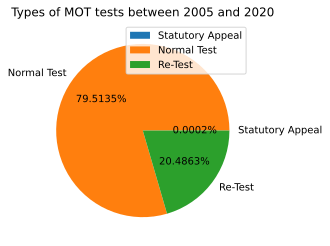

In [29]:
ax = df.plot.pie(y='Number of tests', autopct='%.4f%%')
ax.set_ylabel('')
ax.set_title('Types of MOT tests between 2005 and 2020')
plt.savefig("charts/01 - Types of tests.svg", bbox_inches="tight")
plt.show()

In [34]:
df = pd.read_sql_query("""
    SELECT
        test_classes.test_class as "Test class",
        count(*) AS "Number of tests"
    FROM
        tests
    LEFT JOIN
        test_classes ON test_classes.test_class_id = tests.test_class_id
    GROUP BY
        tests.test_class_id
    ORDER BY
        tests.test_class_id
""", con, index_col='Test class')
df

,Number of tests
Test class,
Pre-computerisation test,37501
Motor bicyceles up to 200 cm3,4290414
All motor bicycles,11655334
3 wheeled vehicles under 450 kg,215193
Cars and other vehicles with up to 12 passenger seats,521429811
Vehicles with 13 or more passenger seats,808400
Goods vehicles between 3000 kg and 3500 kg,12719990


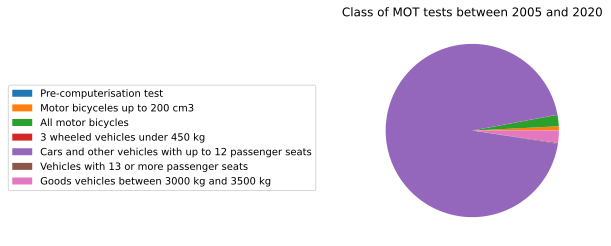

In [62]:
ax = df.plot.pie(y='Number of tests', labeldistance=None)
ax.set_ylabel('')
ax.set_title('Class of MOT tests between 2005 and 2020')
plt.legend(loc="lower right", bbox_to_anchor=(-0.2,0.2))
plt.savefig("charts/02 - Classes of tests.svg", bbox_inches="tight")
plt.show()

In [64]:
df = pd.read_sql_query("""
    SELECT
        strftime('%Y', test_date) as Year,
        count(*) AS "Number of MOTs"
    FROM
        tests
    WHERE
        test_class_id=4 AND test_type='NT'
    GROUP BY 
        year
    ORDER BY
        year
""", con, index_col='Year')

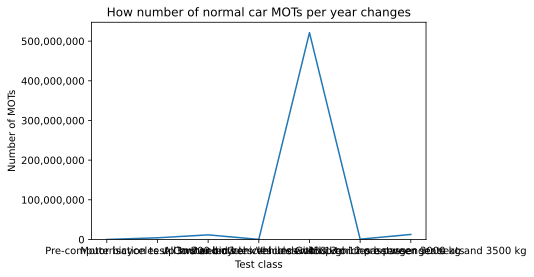

In [63]:
df.plot(legend=None)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylim(ymin=0)
ax.set_ylabel("Number of MOTs")
ax.set_title('How number of normal car MOTs per year changes')
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
plt.savefig("charts/03 - Number of MOTs versus Year.svg", bbox_inches="tight")
plt.show()